In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [12]:

df = pd.read_csv('chart.csv')

df = pd.read_csv('chart.csv')

df['timestamp'] = pd.to_datetime(df['time_in_seconds'], unit='s', origin='unix')

df['minute'] = (df['time_in_seconds'] // 60).astype(int)

total_messages_per_minute = df.groupby('minute').size().reset_index(name='message_count')

member_messages_per_minute = df[df['author_title'] == 'Member'].groupby('minute').size().reset_index(name='message_count')

display(total_messages_per_minute.head())
member_messages_per_minute.head()

,minute,message_count
0,0,137
1,1,160
2,2,99
3,3,113
4,4,345


,minute,message_count
0,0,84
1,1,101
2,2,66
3,3,75
4,4,229


In [7]:
time_labels = pd.to_datetime(total_messages_per_minute['minute'], unit='m').dt.strftime('%H:%M')

time_labels_10min = time_labels[::10]
minutes_10min = total_messages_per_minute['minute'][::10]
display(minutes_10min.head())
time_labels_10min.head()

0      0
10    10
20    20
30    30
40    40
Name: minute, dtype: int64

0     00:00
10    00:10
20    00:20
30    00:30
40    00:40
Name: minute, dtype: object

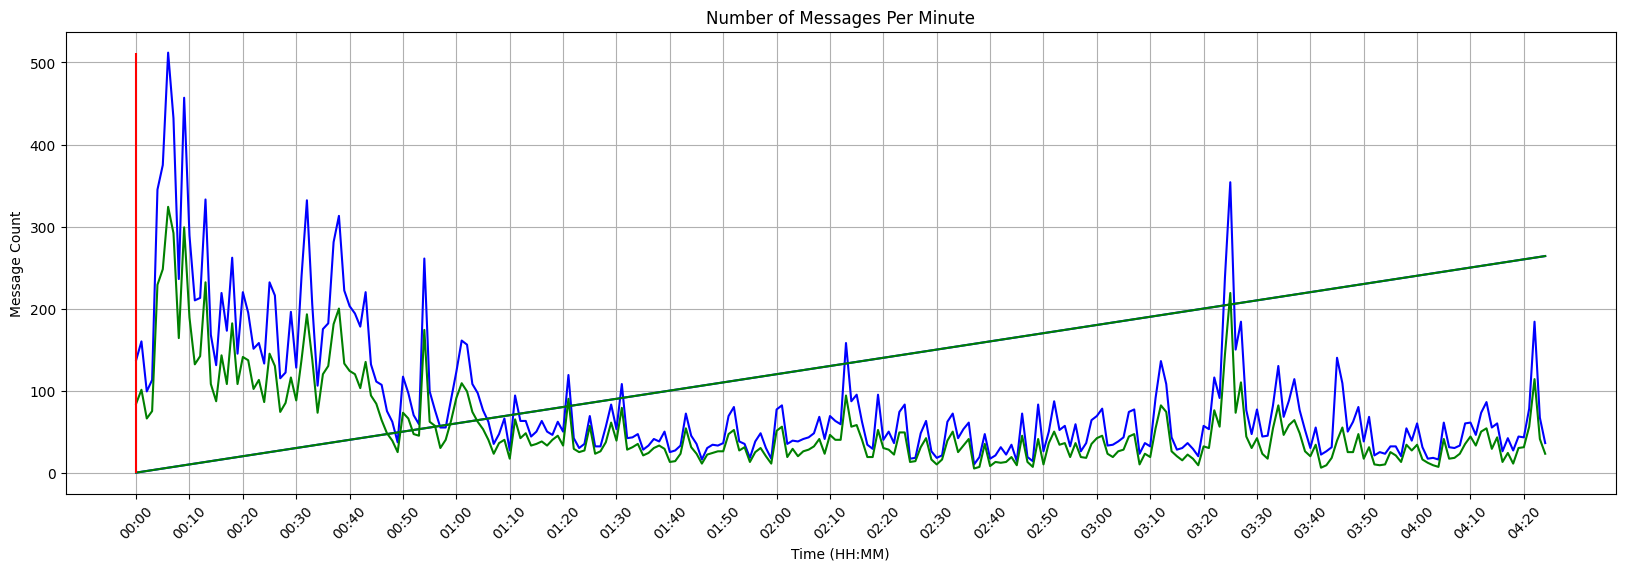

In [9]:
plt.figure(figsize=(20, 6))

plt.plot(total_messages_per_minute['minute'], total_messages_per_minute['message_count'], label='Total Messages', color='blue')

plt.plot(member_messages_per_minute['minute'], member_messages_per_minute['message_count'], label='Member Messages', color='green')


plt.vlines(0, ymin=0, ymax=total_messages_per_minute['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True)
plt.show()